...............Reading the Dataset and Dataset Pre-Processing................
Time Cost for Pre-processing and Reading the Dataset: 0.095658 seconds

............... Initializing hyperparameters and Architecture Grid ................
Architecture: [6]
Architecture: [10]
Architecture: [8, 6]
Architecture: [12, 12, 6]
Architecture: [15]
Time Cost for Training and Evaluating Models: 2.372479 seconds

............... Results ................
Architecture    RMSE       R²         VAF        MAE       
[12, 12, 6]     0.0423 0.6082 61.8385 2.8460
[6]             0.2464 -12.2868 -25.2716 23.8501
[15]            0.2863 -16.9441 -426.5410 25.5097
[10]            0.3257 -22.2193 -58.5276 31.4357
[8, 6]          0.3430 -24.7624 -4.8313 33.5991

Best Architecture: [12, 12, 6]


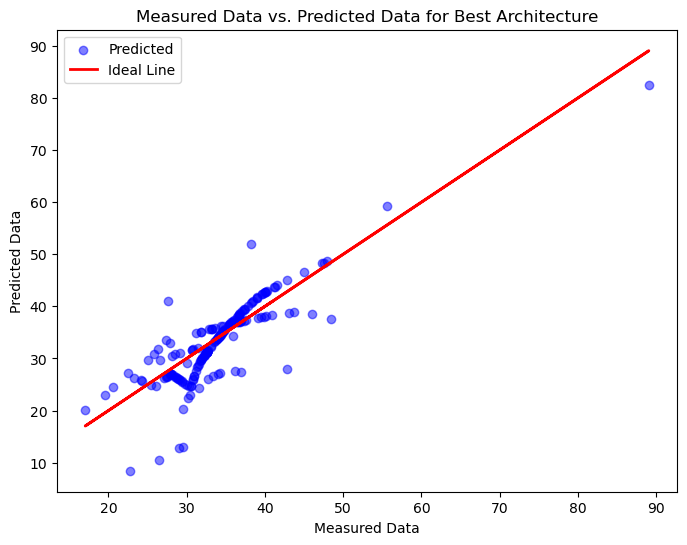

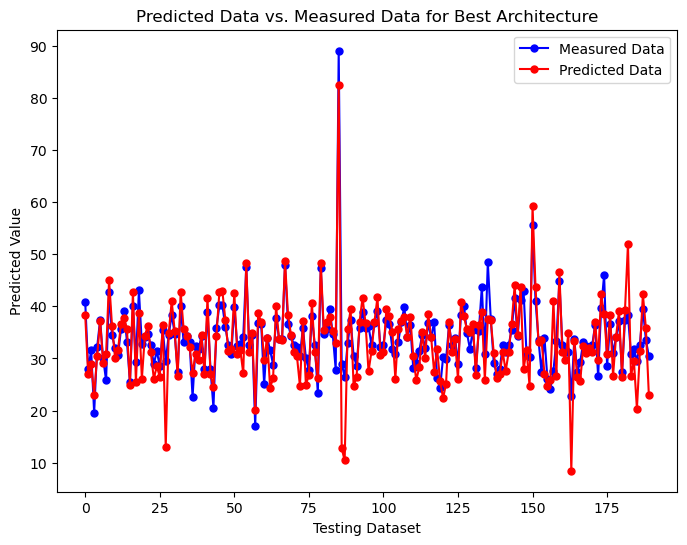

In [6]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pre
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Function to train and evaluate the neural network with a given architecture
def train_and_evaluate_network(architecture, x_train, y_train, x_test, y_test):
    # ReLU Activation function
    def relu(x):
        return np.maximum(0, x)

    # Derivative of ReLU
    def derivative_relu(x):
        return (x > 0).astype(int)

    # Initialize weights
    np.random.seed(39)
    inp = 10
    out = 1
    weights = []
    for i in range(len(architecture)):
        if i == 0:
            weights.append(np.random.randn(inp, architecture[i]))
        else:
            weights.append(np.random.randn(architecture[i-1], architecture[i]))
    weights.append(np.random.randn(architecture[-1], out))

    rmse_list = []
    r2_list = []
    vaf_list = []
    mae_list = []
    epochs = 500
    eta = 0.0001
    alpha = 0.7
    best_rmse = float('inf')
    best_weights = None

    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)  # Split training set into train and validation sets

    for epoch in range(epochs):
        # Feedforward for hidden layers by calling activation function
        layer_outs = []
        layer_outs.append(relu(np.dot(x_train, weights[0])))
        for i in range(1, len(architecture)):
            layer_outs.append(relu(np.dot(layer_outs[i-1], weights[i])))

        output = np.dot(layer_outs[-1], weights[-1])
        final_out = relu(output)

        rmse = np.sqrt(np.mean(np.square(final_out - y_train))) / 100
        rmse_list.append(rmse)

        # Early stopping if RMSE on validation set starts to increase
        val_output = np.dot(relu(np.dot(x_val, weights[0])), weights[1])
        val_final_out = relu(val_output)
        val_rmse = np.sqrt(np.mean(np.square(val_final_out - y_val))) / 100
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_weights = weights.copy()
        else:
            # Restore the best weights and stop training
            weights = best_weights
            break

        # Calculate R²
        ssr = np.sum((y_train - final_out) ** 2)
        sst = np.sum((y_train - np.mean(y_train)) ** 2)
        r2 = 1 - (ssr / sst)
        r2_list.append(r2)

        # Calculate VAF
        vaf = (1 - (np.var(y_train - final_out) / np.var(y_train))) * 100
        vaf_list.append(vaf)

        # Calculate MAE
        mae = np.mean(np.abs(y_train - final_out))
        mae_list.append(mae)

        # Backpropagation for hidden layers
        final_err = final_out - y_train
        final_relu_derivative = derivative_relu(final_out)

        errors = []
        errors.append(np.dot(final_err * final_relu_derivative, weights[-1].T))
        derivatives = []
        derivatives.append(errors[0] * derivative_relu(layer_outs[-1]))

        for i in range(len(architecture) - 2, -1, -1):
            errors.insert(0, np.dot(derivatives[0], weights[i+1].T))
            derivatives.insert(0, errors[0] * derivative_relu(layer_outs[i]))

        # Update weights
        for i in range(len(architecture)):
            if i == 0:
                weights[i] -= eta * alpha * np.dot(x_train.T, derivatives[i]) / y_train.size
            else:
                weights[i] -= eta * alpha * np.dot(layer_outs[i-1].T, derivatives[i]) / y_train.size
        weights[-1] -= eta * alpha * np.dot(layer_outs[-1].T, final_err * final_relu_derivative) / y_train.size

    # Testing
    layer_outs_test = []
    layer_outs_test.append(relu(np.dot(x_test, weights[0])))
    for i in range(1, len(architecture)):
        layer_outs_test.append(relu(np.dot(layer_outs_test[i-1], weights[i])))

    output_test = np.dot(layer_outs_test[-1], weights[-1])
    final_out_test = relu(output_test)

    # Calculate RMSE
    rmse_test = np.sqrt(np.mean(np.square(final_out_test - y_test))) / 100

    # Calculate R² for test set
    ssr_test = np.sum((y_test - final_out_test) ** 2)
    sst_test = np.sum((y_test - np.mean(y_test)) ** 2)
    r2_test = 1 - (ssr_test / sst_test)

    # Calculate VAF for test set
    vaf_test = (1 - (np.var(y_test - final_out_test) / np.var(y_test))) * 100

    # Calculate MAE for test set
    mae_test = np.mean(np.abs(y_test - final_out_test))

    return rmse_test, r2_test, vaf_test, mae_test, final_out_test

# Read and preprocess the dataset
print("...............Reading the Dataset and Dataset Pre-Processing................")
start_time = time.time()
dataset = shuffle(pd.read_csv("blast_dataset1.csv"))

x = dataset[["B", "S", "H", "D", "TI", "TF", "L", "C", "PF", "RF"]]
y = dataset[["X"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Normalizing data using Standard Scaler Fit Transform
scaler = pre.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Converting pd dataframe to numpy array to match compatibility
y_train = y_train.astype(float).to_numpy()
y_test = y_test.astype(float).to_numpy()

end_time = time.time()
total_time = end_time - start_time
print("Time Cost for Pre-processing and Reading the Dataset: %f seconds\n" % total_time)

print("............... Initializing hyperparameters and Architecture Grid ................")
start_time = time.time()
# Setting Hyperparameters
architectures = [
    [6],
    [10],
    [8, 6],
    [12, 12, 6],
    [15],
]  # List of architectures to try

results = []

# Train and evaluate for each architecture
for architecture in architectures:
    print("Architecture:", architecture)
    rmse, r2, vaf, mae, _ = train_and_evaluate_network(architecture, x_train, y_train, x_test, y_test)
    results.append((architecture, rmse, r2, vaf, mae))

# Sort the results based on RMSE
results.sort(key=lambda x: x[1])

end_time = time.time()
total_time = end_time - start_time
print("Time Cost for Training and Evaluating Models: %f seconds\n" % total_time)

print("............... Results ................")
# Print results in tabular format
headers = ["Architecture", "RMSE", "R²", "VAF", "MAE"]
print("{:<15} {:<10} {:<10} {:<10} {:<10}".format(*headers))
for result in results:
    print("{:<15} {:.4f} {:.4f} {:.4f} {:.4f}".format(str(result[0]), result[1], result[2], result[3], result[4]))

# Print best architecture
best_architecture = results[0][0]
print("\nBest Architecture:", best_architecture)

# Get the best architecture's predictions
_, _, _, _, best_architecture_predictions = train_and_evaluate_network(best_architecture, x_train, y_train, x_test, y_test)

# Plotting the graph of predicted data versus measured data for the best architecture
plt.figure(figsize=(8, 6))
plt.scatter(y_test, best_architecture_predictions, alpha=0.5, c='blue', label='Predicted')  # Set the color of points to blue and add label
plt.plot(y_test, y_test, color='red', linewidth=2, label='Ideal Line')  # Remove linestyle parameter to make the line solid and add label
plt.xlabel("Measured Data")
plt.ylabel("Predicted Data")
plt.title("Measured Data vs. Predicted Data for Best Architecture")
plt.legend()  # Add the legend to the plot
plt.show()

# Plotting the line graph of predicted data versus measured data for the best architecture
plt.figure(figsize=(8, 6))
plt.plot(y_test, label='Measured Data', color='blue', marker='o', linestyle='-', markersize=5)
plt.plot(best_architecture_predictions, label='Predicted Data', color='red', marker='o', linestyle='-', markersize=5)
plt.xlabel("Testing Dataset")
plt.ylabel("Predicted Value")
plt.title("Predicted Data vs. Measured Data for Best Architecture")
plt.legend()
plt.show()

